# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

**BONUS PROBLEMS**
1. If creating a logistic regression, GridSearch Ridge and Lasso for this model and report the best hyperparameter values.
1. Scrape the actual text of the threads using Selenium (you'll learn about this in Webscraping II).
2. Write the actual article that you're pitching and turn it into a blog post that you host on your personal website.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [1]:
import requests
import json
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

In [2]:
URL = "http://www.reddit.com/hot.json"

In [3]:
## YOUR CODE HERE
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
res.status_code

200

In [4]:
res.text[:500]

'{"kind": "Listing", "data": {"modhash": "", "dist": 25, "children": [{"kind": "t3", "data": {"approved_at_utc": null, "subreddit": "nevertellmetheodds", "selftext": "", "author_fullname": "t2_4j9ur7", "saved": false, "mod_reason_title": null, "gilded": 0, "clicked": false, "title": "X-post from r/pics", "link_flair_richtext": [], "subreddit_name_prefixed": "r/nevertellmetheodds", "hidden": false, "pwls": 6, "link_flair_css_class": null, "downs": 0, "thumbnail_height": 140, "hide_score": false, "'

#### Use `res.json()` to convert the response into a dictionary format and set this to a variable. 

```python
data = res.json()
```

### Navigate to find useful data

In [5]:
data = res.json()

In [6]:
print(len(data['data']['children']))

25


In [7]:
data.keys()

dict_keys(['kind', 'data'])

In [8]:
print(json.dumps(res.json(), indent=2, sort_keys=True))

{
  "data": {
    "after": "t3_9g1n7x",
    "before": null,
    "children": [
      {
        "data": {
          "approved_at_utc": null,
          "approved_by": null,
          "archived": false,
          "author": "avi_5194",
          "author_flair_background_color": null,
          "author_flair_css_class": null,
          "author_flair_richtext": [],
          "author_flair_template_id": null,
          "author_flair_text": null,
          "author_flair_text_color": null,
          "author_flair_type": "text",
          "author_fullname": "t2_4j9ur7",
          "banned_at_utc": null,
          "banned_by": null,
          "can_gild": false,
          "can_mod_post": false,
          "category": null,
          "clicked": false,
          "content_categories": null,
          "contest_mode": false,
          "created": 1537064783.0,
          "created_utc": 1537035983.0,
          "crosspost_parent": "t3_9g1nwk",
          "crosspost_parent_list": [
            {
              "

In [9]:
data['data']['children']

[{'kind': 't3',
  'data': {'approved_at_utc': None,
   'subreddit': 'nevertellmetheodds',
   'selftext': '',
   'author_fullname': 't2_4j9ur7',
   'saved': False,
   'mod_reason_title': None,
   'gilded': 0,
   'clicked': False,
   'title': 'X-post from r/pics',
   'link_flair_richtext': [],
   'subreddit_name_prefixed': 'r/nevertellmetheodds',
   'hidden': False,
   'pwls': 6,
   'link_flair_css_class': None,
   'downs': 0,
   'thumbnail_height': 140,
   'hide_score': False,
   'name': 't3_9g3qth',
   'quarantine': False,
   'link_flair_text_color': 'dark',
   'author_flair_background_color': None,
   'subreddit_type': 'public',
   'ups': 10072,
   'domain': 'i.imgur.com',
   'media_embed': {},
   'thumbnail_width': 140,
   'author_flair_template_id': None,
   'is_original_content': False,
   'user_reports': [],
   'secure_media': None,
   'is_reddit_media_domain': False,
   'is_meta': False,
   'category': None,
   'secure_media_embed': {},
   'link_flair_text': None,
   'can_mod_pos

In [10]:
data['data']['children'][0]['data'].keys()

dict_keys(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved', 'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'pwls', 'link_flair_css_class', 'downs', 'thumbnail_height', 'hide_score', 'name', 'quarantine', 'link_flair_text_color', 'author_flair_background_color', 'subreddit_type', 'ups', 'domain', 'media_embed', 'thumbnail_width', 'author_flair_template_id', 'is_original_content', 'user_reports', 'secure_media', 'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed', 'link_flair_text', 'can_mod_post', 'score', 'approved_by', 'thumbnail', 'edited', 'author_flair_css_class', 'author_flair_richtext', 'post_hint', 'content_categories', 'is_self', 'mod_note', 'crosspost_parent_list', 'created', 'link_flair_type', 'wls', 'banned_by', 'author_flair_type', 'contest_mode', 'selftext_html', 'likes', 'suggested_sort', 'banned_at_utc', 'view_count', 'archived', 'no_follow', 'is_crosspostable', 'pinne

In [11]:

# scrapedids = pd.DataFrame(data['data']['children'])
results = []
for child in data['data']['children']:
    results.append(child['data'])
#     scrapedids.append(child['data']['title']['subreddit']['created_utc']['num_comments'])
df = pd.DataFrame(results)

In [12]:
parsed_df = df[['num_comments','title','subreddit','created_utc']]
parsed_df.head()

,num_comments,title,subreddit,created_utc
0,142,X-post from r/pics,nevertellmetheodds,1.537036e+09
1,364,I'm sold,funny,1.537030e+09
2,1231,Picture this,BlackPeopleTwitter,1.537031e+09
3,638,"In this obscure world, memes are facts.",MurderedByWords,1.537030e+09
4,203,I DON'T WANT TO BE RESCUED,AnimalsBeingJerks,1.537026e+09


In [13]:
parsed_df.shape

(25, 4)

#### Getting more results

By default, Reddit will give you the top 25 posts:

```python
print(len(data['data']['children']))
```

If you want more, you'll need to do two things:
1. Get the name of the last post: `data['data']['after']`
2. Use that name to hit the following url: `http://www.reddit.com/hot.json?after=THE_AFTER_FROM_STEP_1`
3. Create a loop to repeat steps 1 and 2 until you have a sufficient number of posts. 

*NOTE*: Reddit will limit the number of requests per second you're allowed to make. When you create your loop, be sure to add the following after each iteration.

```python
time.sleep(3) # sleeps 3 seconds before continuing```

This will throttle your loop and keep you within Reddit's guidelines. You'll need to import the `time` library for this to work!

In [14]:
data['data'].keys()

dict_keys(['modhash', 'dist', 'children', 'after', 'before'])

In [15]:
## YOUR CODE HERE
data['data']['after']

't3_9g1n7x'

In [16]:
import time 
df2=pd.DataFrame()

for i in range (150):
    url= "http://www.reddit.com/hot.json?after="+data['data']['after']
    res = requests.get(url, headers = {'User-agent': 'JPH Bot 0.1'})
    time.sleep(3)
    time_fetched = pd.Timestamp.utcnow()
    data = res.json()
    post = [child['data'] for child in data['data']['children']]
    df2= pd.concat([pd.DataFrame(post),df2],sort=True)
res.status_code   

200

In [18]:
df2.shape

(3750, 97)

In [19]:
parsed_df2 = df2[['num_comments','title','subreddit','created_utc']]

In [20]:
parsed_df2.head()

,num_comments,title,subreddit,created_utc
0,705,This little man made himself at home while I c...,aww,1.536992e+09
1,1346,US Admiral who led Bin Laden raid resigns from...,worldnews,1.536989e+09
2,5836,Men of Reddit: How comfortable are you with a ...,AskReddit,1.536983e+09
3,919,Guy spills sweet tea,WatchPeopleDieInside,1.536997e+09
4,234,A father buys a lie detector that slaps people...,Jokes,1.537012e+09


In [21]:
parsed_df2.shape

(3750, 4)

## (Optional) Collect more information

While we only require you to collect four features, there may be other info that you can find on the results page that might be useful. Feel free to write more functions so that you have more interesting and useful data.

In [22]:
## YOUR CODE HERE

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [2]:
# Export to csv
parsed_df2.to_csv("reddit.csv", index=False)

NameError: name 'parsed_df2' is not defined

## Predicting comments using Random Forests + Another Classifier

#### Load in the the data of scraped results

In [29]:
data=pd.read_csv("reddit.csv")

In [30]:
data.head()

,num_comments,title,subreddit,created_utc
0,705,This little man made himself at home while I c...,aww,1.536992e+09
1,1346,US Admiral who led Bin Laden raid resigns from...,worldnews,1.536989e+09
2,5836,Men of Reddit: How comfortable are you with a ...,AskReddit,1.536983e+09
3,919,Guy spills sweet tea,WatchPeopleDieInside,1.536997e+09
4,234,A father buys a lie detector that slaps people...,Jokes,1.537012e+09


## EDA

In [31]:
data.shape

(3750, 4)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750 entries, 0 to 3749
Data columns (total 4 columns):
num_comments    3750 non-null int64
title           3750 non-null object
subreddit       3750 non-null object
created_utc     3750 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 117.3+ KB


In [33]:
data.isnull().sum()

num_comments    0
title           0
subreddit       0
created_utc     0
dtype: int64

In [34]:
data['Time']=(pd.to_datetime(data['created_utc'],unit='ms'))


In [35]:
data['Time'] = data['Time'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

In [36]:
data.head()

,num_comments,title,subreddit,created_utc,Time
0,705,This little man made himself at home while I c...,aww,1.536992e+09,1970-01-18 13:56:32.073000-05:00
1,1346,US Admiral who led Bin Laden raid resigns from...,worldnews,1.536989e+09,1970-01-18 13:56:28.826000-05:00
2,5836,Men of Reddit: How comfortable are you with a ...,AskReddit,1.536983e+09,1970-01-18 13:56:22.777000-05:00
3,919,Guy spills sweet tea,WatchPeopleDieInside,1.536997e+09,1970-01-18 13:56:37.035000-05:00
4,234,A father buys a lie detector that slaps people...,Jokes,1.537012e+09,1970-01-18 13:56:51.836000-05:00


In [37]:
data = data.rename(columns={'num_comments': 'Comments', 'title': 'Title','subreddit': 'Subreddit'})

In [38]:
data['Subreddit'].sort_values(ascending=False).head(25) #just seeing the top 25 subreddits


1142         youtubehaiku
1635         youtubehaiku
681          youtubehaiku
1373         youtubehaiku
3052    youseeingthisshit
1940       yesyesyesyesno
742        yesyesyesyesno
893           yesyesyesno
2668          yesyesyesno
1053          yesyesyesno
3356          yesyesyesno
3185                xqcow
3127                xqcow
1770                 xkcd
1728                 xkcd
2657              xboxone
1394              xboxone
2704             wwiipics
3066             wwiipics
2899             wwiipics
3118       wtfstockphotos
521        wtfstockphotos
2901       wtfstockphotos
3189     wowthissubexists
1116     wowthanksimcured
Name: Subreddit, dtype: object

In [39]:
data.Comments.value_counts(ascending=False).head(10) #just seeing the distribution of the number of comments
#using value counts in descending order.

2     124
1     110
3     107
6     104
5      92
0      91
4      80
7      75
11     73
9      71
Name: Comments, dtype: int64

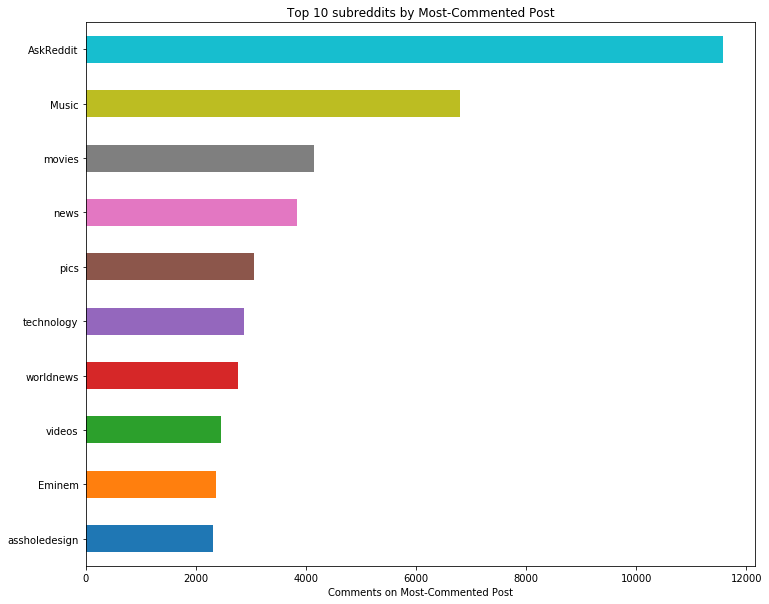

In [40]:
plt.figure(figsize = (12,10))
data.groupby('Subreddit')['Comments'].max().sort_values().tail(10).plot(kind='barh')
plt.title('Top 10 subreddits by Most-Commented Post')
plt.xlabel('Comments on Most-Commented Post')
plt.ylabel("")
plt.show()

In [41]:
data['Date'] = data['Time'].apply(lambda x:x.date().strftime('%m-%d-%y'))

In [42]:
data['Hour_of_Day'] = np.abs(data.Time.dt.hour - 5)

I find wordcloud on internet and it was interesting for me , that why i represent it here . 

In [43]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

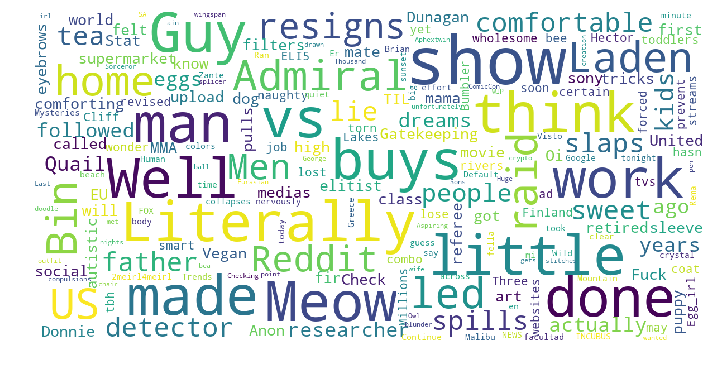

In [44]:
show_wordcloud(data['Title'])

#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

#### 1-Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

In [45]:
## YOUR CODE HERE
med_comments = data['Comments'].median() 
data['Above_Below_Median'] = np.where(data['Comments']>=med_comments,1 ,0 )

In [46]:
med_dist = data['Above_Below_Median'].value_counts()/len(data)
med_dist

1    0.505067
0    0.494933
Name: Above_Below_Median, dtype: float64

#### Thought experiment: What is the baseline accuracy for this model?

In [22]:
## YOUR CODE HERE
from sklearn.metrics import accuracy_score
baseline=accuracy_score(y,y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [3750, 375]

#### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

In [49]:
## YOUR CODE HERE
X = pd.get_dummies(data['Subreddit'])
y = data['Above_Below_Median']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
forest = RandomForestClassifier(max_depth = 20, n_estimators=5, random_state=42)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.6026666666666667

#### Create a few new variables in your dataframe to represent interesting features of a thread title.
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

### Natural Language Processing


In [81]:
## YOUR CODE HERE
X = data['Title']
y = data['Above_Below_Median']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [88]:
cvec = CountVectorizer(stop_words='english', max_features=300)# 300 is the words number
cvecdata = cvec.fit_transform(X_train)
cvec_df  = pd.DataFrame(cvecdata.todense(),
             columns=cvec.get_feature_names())

* 100 in max_features is the word number and in the datafram(cvec_df) is the number of columns

In [89]:
cvec_df.head()

,10,14,20,2018,2meirl4meirl,50,abnormalities,accept,actually,administration,...,woman,won,work,working,world,worst,writers,wrong,year,years
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
cvec_df.cat.value_counts()

0    2610
1      14
2       1
Name: cat, dtype: int64

In [91]:
combined_df = pd.concat([data, cvec_df], axis=1, join_axes=[data.index])

In [92]:
tvec = TfidfVectorizer(stop_words='english', max_features=200)
tvec.fit(X_train)
tvec_df= pd.DataFrame(tvec.transform(X_train).todense(),
                   columns=tvec.get_feature_names(),
                   index=[X_train])

In [93]:
tvec_df.head()

,10,14,20,2018,2meirl4meirl,50,accept,actually,administration,admiral,...,websites,white,wife,woman,won,work,world,writers,year,years
Title,,,,,,,,,,,,,,,,,,,,,
Wife and I went to go pick up the kids from school. When we came back there was four puppies cuddled up in the back corner of our carport. Meet the four newest members of our family.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.453425,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPIC Games right now.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gatekeeping all social medias,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Jeremy Corbyn: Michael Foot loved this country. That's why he wanted to make it better for everyone. Smearing a dead man, who successfully defended himself when he was alive, is about as low as you can go.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
My dearest friend (Crackn on DevianArt),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
combined_df.isnull().sum()

Comments                 0
Title                    0
Subreddit                0
created_utc              0
Time                     0
Date                     0
Hour_of_Day              0
Above_Below_Median       0
10                    1125
14                    1125
20                    1125
2018                  1125
2meirl4meirl          1125
50                    1125
abnormalities         1125
accept                1125
actually              1125
administration        1125
admiral               1125
africa                1125
ago                   1125
air                   1125
alternatives          1125
american              1125
amp                   1125
anon                  1125
art                   1125
artist                1125
artists               1125
artwork               1125
                      ... 
unreal                1125
upload                1125
use                   1125
used                  1125
ve                    1125
vegan                 1125
v

In [95]:
combined_df=combined_df.dropna()

In [101]:
## YOUR CODE HERE
y = combined_df['Above_Below_Median']
X_2 = combined_df['cat'],['Subreddit']

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

This function calculates the confusion matrix, accuracy, sensitivity and specificity. 
In this situation for classification evaluation metrics.

In [51]:
## YOUR CODE HERE
from sklearn.metrics import confusion_matrix
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
tn = conf_matrix[0][0] #true negative
tp = conf_matrix[1][1] #true positive
fn = conf_matrix[1][0] #false negative 
fp = conf_matrix[0][1] #false positive

Accuracy = (tp + tn) / (tp + tn + fp + fn)
Sensitivity = tp / (tp + fn)
Specificity = tn / (tn + fp)
    
print('Accuracy',Accuracy)  
print('Sensitivity',Sensitivity)  
print('Specificity',Specificity)  

Accuracy 0.6026666666666667
Sensitivity 0.26631853785900783
Specificity 0.9536784741144414


#### Repeat the model-building process with a non-tree-based method.

### KNN classifier model 


In [52]:
## YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
clf = KNeighborsClassifier(n_neighbors = 5)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.616

### logistc regression model 

In [53]:
X = pd.get_dummies(data['Subreddit'],['Title'])
y = data['Above_Below_Median']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

lm = LogisticRegression()
lm.fit(X_train, y_train)
lm.predict(X_test)
lm.score(X_test, y_test)

0.7413333333333333

In [54]:
gs_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=5, verbose=1)
lr_gridsearch = lr_gridsearch.fit(X_train, y_train)
print ('best_params_',lr_gridsearch.best_params_ )
print ('best_score_',lr_gridsearch.best_score_ )
print ('score_',lr_gridsearch.score(X_test, y_test))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
best_params_ {'C': 0.06892612104349695, 'penalty': 'l2', 'solver': 'liblinear'}
best_score_ 0.7644444444444445
score_ 0.7413333333333333


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   30.0s finished


### the score  of logistc regression seem  better than KNN 

#### Use Count Vectorizer from scikit-learn to create features from the thread titles. 
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

### Natural Language Processing

In [55]:
## YOUR CODE HERE
X = data['Title']
y = data['Above_Below_Median']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [56]:
cvec = CountVectorizer(stop_words='english', max_features=100)# 100 is the words number
cvecdata = cvec.fit_transform(X_train)
cvec_df  = pd.DataFrame(cvecdata.todense(),
             columns=cvec.get_feature_names())

* 100 in max_features is the word number and in the datafram(cvec_df) is the number of columns

In [57]:
cvec_df.head()

,10,2meirl4meirl,50,actually,ago,amp,art,best,black,bpa,...,vs,wait,want,way,white,woman,work,world,year,years
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
cvec_df.actually.value_counts()

0    2599
1      26
Name: actually, dtype: int64

In [59]:
tvec = TfidfVectorizer(stop_words='english', max_features=100)
tvec.fit(X_train)
tvec_df= pd.DataFrame(tvec.transform(X_train).todense(),
                   columns=tvec.get_feature_names(),
                   index=[X_train])

In [60]:
tvec_df.head()

,10,2meirl4meirl,50,actually,ago,amp,art,best,black,bpa,...,vs,wait,want,way,white,woman,work,world,year,years
Title,,,,,,,,,,,,,,,,,,,,,
Wife and I went to go pick up the kids from school. When we came back there was four puppies cuddled up in the back corner of our carport. Meet the four newest members of our family.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPIC Games right now.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gatekeeping all social medias,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Jeremy Corbyn: Michael Foot loved this country. That's why he wanted to make it better for everyone. Smearing a dead man, who successfully defended himself when he was alive, is about as low as you can go.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
My dearest friend (Crackn on DevianArt),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
combined_df = pd.concat([data, cvec_df], axis=1, join_axes=[data.index])

In [62]:
combined_df.head()

,Comments,Title,Subreddit,created_utc,Time,Date,Hour_of_Day,Above_Below_Median,10,2meirl4meirl,...,vs,wait,want,way,white,woman,work,world,year,years
0,705,This little man made himself at home while I c...,aww,1.536992e+09,1970-01-18 13:56:32.073000-05:00,01-18-70,8,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1346,US Admiral who led Bin Laden raid resigns from...,worldnews,1.536989e+09,1970-01-18 13:56:28.826000-05:00,01-18-70,8,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5836,Men of Reddit: How comfortable are you with a ...,AskReddit,1.536983e+09,1970-01-18 13:56:22.777000-05:00,01-18-70,8,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,919,Guy spills sweet tea,WatchPeopleDieInside,1.536997e+09,1970-01-18 13:56:37.035000-05:00,01-18-70,8,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,234,A father buys a lie detector that slaps people...,Jokes,1.537012e+09,1970-01-18 13:56:51.836000-05:00,01-18-70,8,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
combined_df.isnull().sum()

Comments                 0
Title                    0
Subreddit                0
created_utc              0
Time                     0
Date                     0
Hour_of_Day              0
Above_Below_Median       0
10                    1125
2meirl4meirl          1125
50                    1125
actually              1125
ago                   1125
amp                   1125
art                   1125
best                  1125
black                 1125
bpa                   1125
buys                  1125
called                1125
cat                   1125
chicken               1125
class                 1125
corn                  1125
daughter              1125
day                   1125
days                  1125
decided               1125
did                   1125
didn                  1125
                      ... 
really                1125
reddit                1125
right                 1125
say                   1125
says                  1125
school                1125
s

In [64]:
combined_df=combined_df.dropna()

In [67]:
X = combined_df.iloc[:,18:]
y = combined_df['Above_Below_Median']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
forest = RandomForestClassifier(max_depth = 10, n_estimators=5, random_state=42)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.501269035532995

In [68]:
from sklearn.metrics import confusion_matrix
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
tn = conf_matrix[0][0] #true negative
tp = conf_matrix[1][1] #true positive
fn = conf_matrix[1][0] #false negative 
fp = conf_matrix[0][1] #false positive

Accuracy = (tp + tn) / (tp + tn + fp + fn)
Sensitivity = tp / (tp + fn)
Specificity = tn / (tn + fp)
    
print('Accuracy',Accuracy)  
print('Sensitivity',Sensitivity)  
print('Specificity',Specificity) 

Accuracy 0.501269035532995
Sensitivity 0.8905472636815921
Specificity 0.09585492227979274


This model is relatively the seem of the first model in terms of specificity . It has a high specificity and low sensitivity. It means it is able to detect more true negatives than false negatives than it is able to detect more true positives than false positives. I probably don't want to use this model if I want to maximize sensitivity but it ia better than first model.

# Executive Summary
---
Put your executive summary in a Markdown cell below.

### BONUS
Refer to the README for the bonus parts

## YOUR CODE HERE
you can find my Executive Summary in README file .

In [103]:
data.sort_values("Comments", ascending=False)[["Title",  "Comments", "Subreddit"]].drop_duplicates("Title")

,Title,Comments,Subreddit
1353,What company policy at your job might actually...,11579,AskReddit
1371,Eminem’s response to MGK,6805,Music
2,Men of Reddit: How comfortable are you with a ...,5836,AskReddit
11,Ever got movie high? Like when the world felt ...,4142,movies
3543,Bronx teacher who performed oral sex on 14-yea...,3842,news
1069,A year ago my fiancé and I decided to get in s...,3062,pics
1657,You are immediately transported to one hour in...,2905,AskReddit
903,Almost half of US cellphone calls will be scam...,2872,technology
831,Russia reportedly warned Mattis it could use n...,2766,worldnews
570,"50 Cent on His Respect for Eminem: ""Hip hop is...",2461,videos
